# Определение перспективного тарифа для телеком-компании

## Описание проекта
Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Компания предлагает клиентам два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов
#### Тариф «Смарт»
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   - минута разговора: 3 рубля
   - сообщение: 3 рубля
   - 1 Гб интернет-трафика: 200 рублей
   
#### Тариф «Ультра»
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
   - минута разговора: 1 рубль
   - сообщение: 1 рубль
   - 1 Гб интернет-трафика: 150 рублей
   
#### Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

### План работы
1. Изучить общую информацию
2. Подготовить данные
   - Привести данные к нужным типам;
   - Найти и исправить ошибки в данных, если они есть;
   - Определить и добавить необходимые в работе дополнительные расчеты.
3. Проанализировать данные
4. Проверить гипотезы
   - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
   - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
5. Подготовить общий вывод

### Описание данных
#### Таблица users (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана
#### Таблица calls (информация о звонках):
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок
#### Таблица messages (информация о сообщениях):
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение
#### Таблица internet (информация об интернет-сессиях):
- `id` — уникальный номер сессии
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session`_date — дата интернет-сессии
- `user_id` — идентификатор пользователя
#### Таблица tariffs (информация о тарифах):
- `tariff_name` — название тарифа
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Обзор данных

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
from scipy import stats as st

In [2]:
# загружаю данные
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv', index_col=0)
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

In [3]:
display(calls.head())
calls.info()  

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [4]:
display(internet.head())
internet.info()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


In [5]:
display(messages.head())
messages.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [6]:
display(tariffs)
tariffs.info()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [7]:
display(users.head())
users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [8]:
display(calls.duplicated().sum())
display(internet.duplicated().sum())
display(messages.duplicated().sum())
display(users.duplicated().sum())

0

0

0

0

### Вывод:
Пропущенных значений и дубликатов не обнаружено. Так как компания всегда округляет секунды до минут отдельно по каждому звонку, то необходимо сразу округлить значения в duration таблицы calls. Также потребуется изменить типы данных:
* call_date в calls с object на datetime64
* session_date в internet с object на datetime64
* message_date в messages с object на datetime64
* churn_date в users с object на datetime64

## Подготовка данных

In [9]:
# округляю продолжительность
calls['duration'] = np.ceil(calls['duration'])

In [10]:
# меняю типы данных
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

In [11]:
# проверяю данные о тарифах и возрасте
display(users.query('age < 18'))
users['tariff'].value_counts()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff


smart    351
ultra    149
Name: tariff, dtype: int64

### Вывод
Столбцы содержащие даты приведены к формату datetime64. Продолжительность звонков округлена до целых минут согласно условиям оплаты. Все пользователи совершеннолетние, тарифы только те, что являются предметом исследования, то есть каких-либо ошибок в данных не обнаружено.

Для дальнейшей работы потребуются дополнительные данные по каждому пользователю, а именно:
* количество сделанных звонков по месяцам
* количество израсходованных минут разговора по месяцам
* количество отправленных сообщений по месяцам
* объем израсходованного интернет-трафика по месяцам
* помесячную выручку с каждого пользователя

In [12]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls.head()

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.0,1000,7
1,1000_1,2018-08-17,0.0,1000,8
2,1000_2,2018-06-11,3.0,1000,6
3,1000_3,2018-09-21,14.0,1000,9
4,1000_4,2018-12-15,6.0,1000,12


In [13]:
calls_per_month = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum']).reset_index()
calls_per_month.columns = ['user_id', 'month', 'calls_total', 'calls_duration']
calls_per_month.head(15)

,user_id,month,calls_total,calls_duration
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
5,1000,10,57,350.0
6,1000,11,43,338.0
7,1000,12,46,333.0
8,1001,11,59,430.0
9,1001,12,63,414.0


In [14]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages_per_month = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').reset_index()
messages_per_month.columns = ['user_id', 'month', 'messages_total']
messages_per_month.head()

,user_id,month,messages_total
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [15]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet_per_month = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum').reset_index()
internet_per_month.head()

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [16]:
internet_per_month['mb_used'] = internet_per_month['mb_used'] / 1024
internet_per_month.columns = ['user_id', 'month', 'gb_used']
internet_per_month['gb_used'] = np.ceil(internet_per_month['gb_used'])
internet_per_month.head()

,user_id,month,gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


In [17]:
# объединяю таблицы
data_1 = calls_per_month.merge(messages_per_month, on=['user_id', 'month'], how='outer')
data_2 = data_1.merge(internet_per_month, on=['user_id', 'month'], how='outer')
data_3 = data_2.merge(users[['user_id', 'tariff', 'city']], on='user_id', how='outer')
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})
data = data_3.merge(tariffs, on='tariff', how='outer')
data.sample(5)

,user_id,month,calls_total,calls_duration,messages_total,gb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
2456,1321,10.0,61.0,411.0,24.0,18.0,smart,Москва,50,15360,500,550,200,3,3
1237,1054,9.0,90.0,672.0,65.0,19.0,smart,Омск,50,15360,500,550,200,3,3
720,1381,12.0,104.0,762.0,55.0,22.0,ultra,Москва,1000,30720,3000,1950,150,1,1
1170,1037,12.0,54.0,408.0,26.0,12.0,smart,Череповец,50,15360,500,550,200,3,3
2260,1280,12.0,85.0,479.0,51.0,20.0,smart,Астрахань,50,15360,500,550,200,3,3


In [18]:
# считаю перелимиты по каждой услуге
data['calls_overrun'] = data['calls_duration'] - data['minutes_included']
data['messages_overrun'] = data['messages_total'] - data['messages_included']
data['mb_per_month_included'] = data['mb_per_month_included'] / 1024
data = data.rename(columns={'mb_per_month_included': 'gb_per_month_included'})
data['gb_per_month_included'] = np.ceil(data['gb_per_month_included'])
data['internet_overrun'] = data['gb_used'] - data['gb_per_month_included']
data.sample(5)

,user_id,month,calls_total,calls_duration,messages_total,gb_used,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_overrun,messages_overrun,internet_overrun
255,1152,4.0,38.0,281.0,NaN,28.0,ultra,Мурманск,1000,30.0,3000,1950,150,1,1,-2719.0,NaN,-2.0
276,1167,11.0,83.0,588.0,148.0,20.0,ultra,Кемерово,1000,30.0,3000,1950,150,1,1,-2412.0,-852.0,-10.0
2136,1248,10.0,113.0,727.0,NaN,21.0,smart,Москва,50,15.0,500,550,200,3,3,227.0,NaN,6.0
68,1049,4.0,76.0,528.0,NaN,6.0,ultra,Москва,1000,30.0,3000,1950,150,1,1,-2472.0,NaN,-24.0
2784,1409,4.0,94.0,753.0,41.0,18.0,smart,Набережные Челны,50,15.0,500,550,200,3,3,253.0,-9.0,3.0


In [19]:
# считаю выручку
def take(df):
    calls_overrun = df['calls_overrun']
    rub_per_minute = df['rub_per_minute']
    messages_overrun = df['messages_overrun']
    rub_per_message = df['rub_per_message']
    internet_overrun = df['internet_overrun']
    rub_per_gb = df['rub_per_gb']
    take = df['rub_monthly_fee']
    if calls_overrun > 0:
        take += calls_overrun * rub_per_minute
    if messages_overrun > 0:
        take += messages_overrun * rub_per_message
    if internet_overrun > 0:
        take += internet_overrun * rub_per_gb
    return take
data['take'] = data.apply(take, axis=1)
data.sample(10)

,user_id,month,calls_total,calls_duration,messages_total,gb_used,tariff,city,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls_overrun,messages_overrun,internet_overrun,take
1837,1183,7.0,40.0,326.0,24.0,10.0,smart,Владивосток,50,15.0,500,550,200,3,3,-174.0,-26.0,-5.0,550.0
2042,1227,5.0,84.0,546.0,38.0,18.0,smart,Санкт-Петербург,50,15.0,500,550,200,3,3,46.0,-12.0,3.0,1288.0
2205,1264,11.0,58.0,349.0,21.0,16.0,smart,Хабаровск,50,15.0,500,550,200,3,3,-151.0,-29.0,1.0,750.0
1251,1055,11.0,49.0,314.0,38.0,21.0,smart,Казань,50,15.0,500,550,200,3,3,-186.0,-12.0,6.0,1750.0
1097,1025,5.0,71.0,552.0,27.0,21.0,smart,Уфа,50,15.0,500,550,200,3,3,52.0,-23.0,6.0,1906.0
2663,1378,4.0,80.0,572.0,17.0,11.0,smart,Иркутск,50,15.0,500,550,200,3,3,72.0,-33.0,-4.0,766.0
776,1402,5.0,92.0,689.0,32.0,27.0,ultra,Пенза,1000,30.0,3000,1950,150,1,1,-2311.0,-968.0,-3.0,1950.0
523,1310,3.0,15.0,106.0,17.0,5.0,ultra,Уфа,1000,30.0,3000,1950,150,1,1,-2894.0,-983.0,-25.0,1950.0
102,1063,8.0,129.0,864.0,NaN,14.0,ultra,Тула,1000,30.0,3000,1950,150,1,1,-2136.0,NaN,-16.0,1950.0
411,1254,7.0,77.0,715.0,NaN,20.0,ultra,Москва,1000,30.0,3000,1950,150,1,1,-2285.0,NaN,-10.0,1950.0


In [20]:
data = data.fillna(0)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3216 non-null   int64  
 1   month                  3216 non-null   float64
 2   calls_total            3216 non-null   float64
 3   calls_duration         3216 non-null   float64
 4   messages_total         3216 non-null   float64
 5   gb_used                3216 non-null   float64
 6   tariff                 3216 non-null   object 
 7   city                   3216 non-null   object 
 8   messages_included      3216 non-null   int64  
 9   gb_per_month_included  3216 non-null   float64
 10  minutes_included       3216 non-null   int64  
 11  rub_monthly_fee        3216 non-null   int64  
 12  rub_per_gb             3216 non-null   int64  
 13  rub_per_message        3216 non-null   int64  
 14  rub_per_minute         3216 non-null   int64  
 15  call

### Вывод
Добавлены расчеты по месяцам с количеством сделанных звонков, количеством израсходованных минут разговора,количеством отправленных сообщений,объемом израсходованного интернет-трафика и помесячной выручкой с каждого пользователя. Образовавшиеся пропуски в значениях новых расчетов там, где абонент не пользовался услугой были заполнены нулями.

## Анализ данных

In [21]:
data_mean = data.pivot_table(index='tariff', values=['calls_duration', 'messages_total', 'gb_used'], aggfunc=['mean', 'var', 'std']).round()
data_mean

mean                                   var          \
       calls_duration gb_used messages_total calls_duration gb_used   
tariff                                                                
smart           418.0    16.0           33.0        36281.0    33.0   
ultra           526.0    19.0           49.0       101052.0    97.0   

                                 std                         
       messages_total calls_duration gb_used messages_total  
tariff                                                       
smart           797.0          190.0     6.0           28.0  
ultra          2285.0          318.0    10.0           48.0

In [22]:
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')

In [23]:
display(data_smart['take'].sum())
data_ultra['take'].sum()

2875901.0

2041050.0

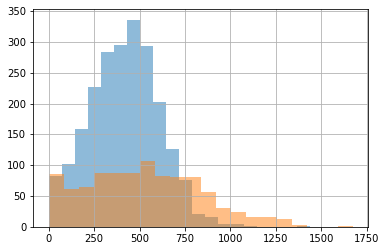

In [24]:
data_smart['calls_duration'].hist(bins=20, alpha=0.5)
data_ultra['calls_duration'].hist(bins=20, alpha=0.5);

Данные по звонкам тарифа Смарт распределелены нормально, пиковое значение в пределах стандартного пакета, при этом довольно большому числу клиентов тарифа Смарт не хватает заложенного пакета в 500 минут, это значит, что они будут доплачивать поминутно, что принесет прибыль компании, хоть среднее значение лежит в пределах стандартного пакета (418 минут) стандартное отклонение выборки тарифа показывает, что доплат однозначно много. Звонки абонентов тарифа Ультра распределены со смещением влево, четко видно, что они не используют отведенные минуты в полном объеме (3000 минут), их среднее потребление не столь значительно превышает минуты пакета Смарт (526 минут), и  даже самые разговорчивае клиенты едва тратят чуть больше половины пакета, что также прибыльно для компании, так как услуга предоставлется в меньшем от планируемого объеме. Кстатити, среди абонентов Смарт также присутствует весомое количество, которое не "договаривает" уже оплаченные абонетской платой минуты.

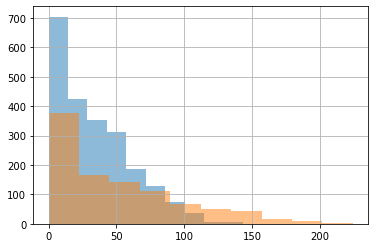

In [25]:
data_smart['messages_total'].hist(alpha=0.5)
data_ultra['messages_total'].hist(alpha=0.5);

Данные по отправленным сообщениям обоих тарифов распределены со смещением влево, это указывает на то, что значительные доли в обоих группах пользуются оплаченной услугой крайне редко или не используют совсем.В среднем абоненты Смарт отправляют 33 сообщения, а Ультра 49. Абонентам Ультра с запасом хватает стандартного пакета сообщений, они едва использую 20% от него, а вот абонентам Смарт иногда не хватает оплаченного пакета.

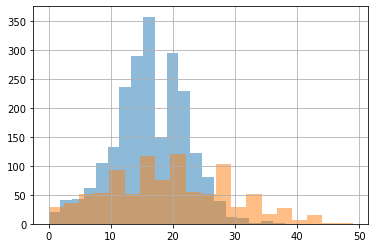

In [26]:
data_smart['gb_used'].hist(bins=20, alpha=0.5)
data_ultra['gb_used'].hist(bins=20, alpha=0.5);

Данные распределены неравномерно, особенно заметно по выборке тарифа Ультра, присутствует несколько пиковых значений, нужна проверка на корректность предоставленных данных. Среднее значение используемого интернета у абонентов Смарт выше, чем стандартный пакет, 16 гигабайт против предложенных 15, то есть более половины пользователей доплачивают за дополнительный инернет трафик. Абонентам Ультра чаще хватает заложенного объема, многие из них используют только половину пакета.

### Вывод
На первый взгляд может показаться, что тариф Смарт более прибыльный, так как его абоненты не редко доплачивают за дополнительные минуты и гигабайты, но исследование показывает, что абоненты Ультра часто оплачивают больший объем услуг, чем им требуется в месяц. Таким образом можно предположить, что средняя выручка по каждому тарифу примерно одинаковая. Далее проверим это утверждение. Также посмотрим есть ли разница в выручке между жителями Москвы и других городов.

## Проверка гипотез

H0: Средняя выручка пользователей тарифов «Ультра» равна средней выручке пользователей тарифов «Смарт». 

H1: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Выборки по тарифам независимые, поэтому для проверки применим гипотезу о равенстве средних двух генеральных совокупностей.

In [27]:
smart_take = data_smart['take']
ultra_take = data_ultra['take']
alpha = .05
results = st.ttest_ind(smart_take, ultra_take, equal_var=False)
display('p-значение:', results.pvalue)
if results.pvalue < alpha:
    display("Отвергаем нулевую гипотезу")
else:
    display("Не получилось отвергнуть нулевую гипотезу")

'p-значение:'

1.927011394420941e-250

'Отвергаем нулевую гипотезу'

H0: Средняя выручка пользователей из Москвы равна средней выручке от пользователей из других регионов.

Н1: Средняя выручка пользователей из Москвы отличается от средней выручки от пользователей из других регионов.

Выборки по городам также независимые, поэтому снова для проверки применим гипотезу о равенстве средних двух генеральных совокупностей.

In [28]:
msk_take = data.query('city == "Москва"')['take']
region_take = data.query('city != "Москва"')['take']
alpha = .05
results = st.ttest_ind(msk_take, region_take, equal_var=False)
display('p-значение:', results.pvalue)
if results.pvalue < alpha:
    display("Отвергаем нулевую гипотезу")
else:
    display("Не получилось отвергнуть нулевую гипотезу")

'p-значение:'

0.5216952110000278

'Не получилось отвергнуть нулевую гипотезу'

In [29]:
#разница в прибыли
(data_smart['take'].sum()) - (data_ultra['take'].sum())

834851.0

### Вывод
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, значение p_value указывает на то, что различия значимые и не случайные, при этом нельзя утверждать, что средняя выручка клиентов из Москвы отличается от средней выручки клиентов из других регионов, существет вероятность в 52%, что существующее или большее различие можно получить случайно.

## Общие выводы

В ходе исследования двух тарифов Смарт и Ультра по выборке клиентов были определены и оценены объемы звонков, сообщений, интернета и прибыли по каждому тарифу, для этого предварительно данные были обработаны на соответствие типов, наличие дубликатов, заполнены пропущенные значения. В результате определено, что прибыль по тарифам отличается, при этом неважно из какого города клиент. Учитывая, что абоненты с тарифам Ультра чаще не расходуют оплаченные пакеты в полном объеме, а также то, что сам тариф стоит более чем в три раза дороже, можно определить, что данный тариф приносит стабильную прибыль. При этом валовая прибыль по выборке Смарт превышает валовую прибыль по Ультра более чем на 800 тысяч. 

Чаще всего перерасход бывает в минутах у клиентов Смарт и в интернет трафике у клиентов обоих тарифов. При расходе 750 минут и прочих услугах в рамках пакета, клиент Смарт заплатит 1000р, а Ультра - 1950р, т.е базовый платеж. При расходе 27 гигабайт интернета в месяц и прочих услугах в рамках пакета, клиент Смарт заплатит 2959р, а Ультра - 1950р. При расходе же 32 гигабайт и прочих услугах в рамках пакета клиент Смарт платит 3950р, а Ультра - 2250р.
Исследование показывает, что потенциально тариф Смарт более прибыльный для компании. Окончательно этот вывод могла бы подтвердить динамика роста объемов трафика за последние годы, а точнее как менялась потребность в каждой из услуг.